# Used Car Price Regression Model

# Introduction

This dataset comes from a collection of UK Used Car listing that were scraped and assembled for use. I chose to start off with the Toyota dataset because I happen to own one myself. The price is in English Pounds but for the use of this notebook I don't think I will be dealing with it - though I suppose I could figure out how to determine the exchange rate into Dollars depending on the year.

# Libraries

In [1]:
# Below are the libraries I will use.
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from sklearn.preprocessing import StandardScaler

import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score

# Load Data

In [52]:
# Load the data
df = pd.read_csv("toyota.csv")
df.head()

,model,year,price,transmission,mileage,fuelType,tax,mpg,engineSize
0,GT86,2016,16000,Manual,24089,Petrol,265,36.2,2.0
1,GT86,2017,15995,Manual,18615,Petrol,145,36.2,2.0
2,GT86,2015,13998,Manual,27469,Petrol,265,36.2,2.0
3,GT86,2017,18998,Manual,14736,Petrol,150,36.2,2.0
4,GT86,2017,17498,Manual,36284,Petrol,145,36.2,2.0


In [53]:
# How many rows/columns are there?
df.shape

(6738, 9)

In [54]:
# Pretty clean data set
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6738 entries, 0 to 6737
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   model         6738 non-null   object 
 1   year          6738 non-null   int64  
 2   price         6738 non-null   int64  
 3   transmission  6738 non-null   object 
 4   mileage       6738 non-null   int64  
 5   fuelType      6738 non-null   object 
 6   tax           6738 non-null   int64  
 7   mpg           6738 non-null   float64
 8   engineSize    6738 non-null   float64
dtypes: float64(2), int64(4), object(3)
memory usage: 473.9+ KB


In [55]:
# Maybe some outliers
df.describe()

,year,price,mileage,tax,mpg,engineSize
count,6738.000000,6738.000000,6738.000000,6738.000000,6738.000000,6738.000000
mean,2016.748145,12522.391066,22857.413921,94.697240,63.042223,1.471297
std,2.204062,6345.017587,19125.464147,73.880776,15.836710,0.436159
min,1998.000000,850.000000,2.000000,0.000000,2.800000,0.000000
25%,2016.000000,8290.000000,9446.000000,0.000000,55.400000,1.000000
50%,2017.000000,10795.000000,18513.000000,135.000000,62.800000,1.500000
75%,2018.000000,14995.000000,31063.750000,145.000000,69.000000,1.800000
max,2020.000000,59995.000000,174419.000000,565.000000,235.000000,4.500000


# EDA

The dataset has 9 features:

* 5 numerical columns: 'price', 'mileage', 'tax', 'mpg' and 'engineSize'
* 3 categorical columns: 'model', 'transmission' and 'fuelType'
* 1 date column: 'year'

In [56]:
# The documentation said it didn't have any null values but I still wanted to check.
df.isna().sum()

model           0
year            0
price           0
transmission    0
mileage         0
fuelType        0
tax             0
mpg             0
engineSize      0
dtype: int64

In [57]:
# Check for duplicates
duplicates = df[df.duplicated()]
print(len(duplicates))

39


In [58]:
# Drop all duplicates
df.drop_duplicates(keep='first',inplace=True)

In [59]:
df.shape

(6699, 9)

## Heteroskedasticity

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f82c0db1950>,
      dtype=object)

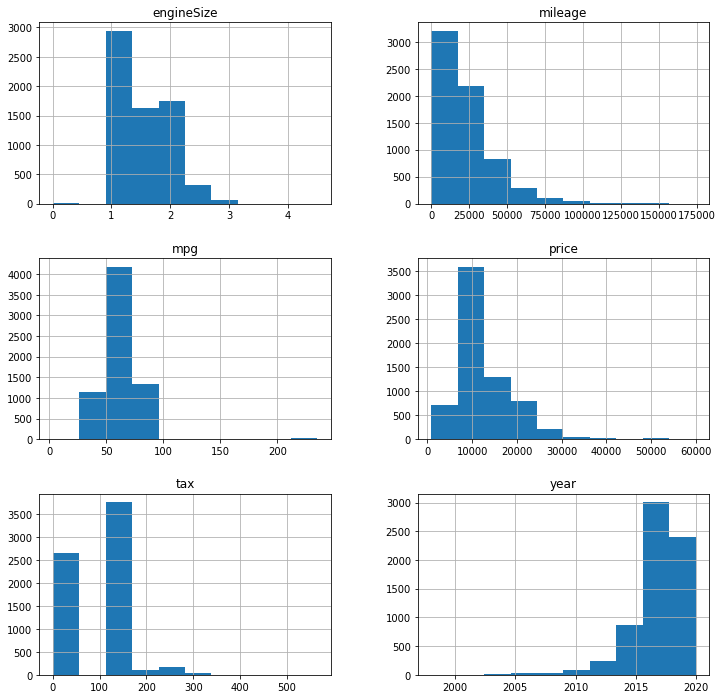

In [60]:
# Histograms to view heteroskedasticity
df.hist(figsize=(12,12))

Most of the continuous features are pretty skewed. Later I will use Standard Scaler to correct this.

## Multicollinearity of Features

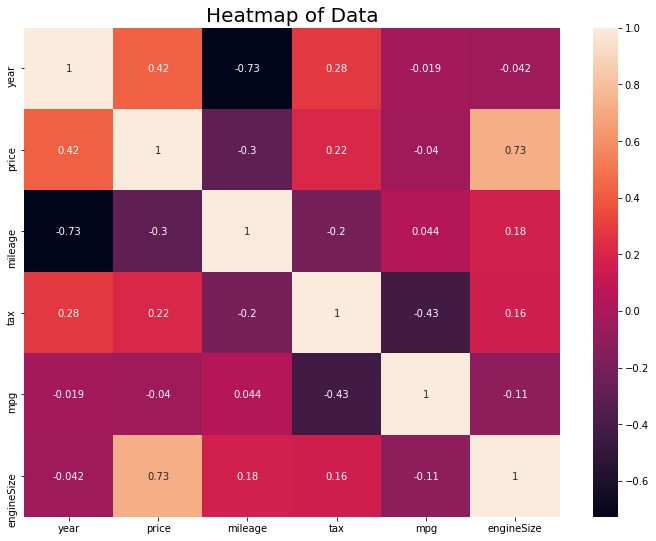

In [61]:
# Heatmap Correlation
fig = plt.figure(figsize = (12,9))
sns.heatmap(df.corr(), annot=True)
plt.title('Heatmap of Data', fontsize = 20)
plt.show()

Mileage and year have a negative correlation - which makes sense. The older the car and the more miles it has the more the price goes down.
Price and engine size have a positive correlation. Meaning that the bigger the engine the more expensive. 

## Linearity

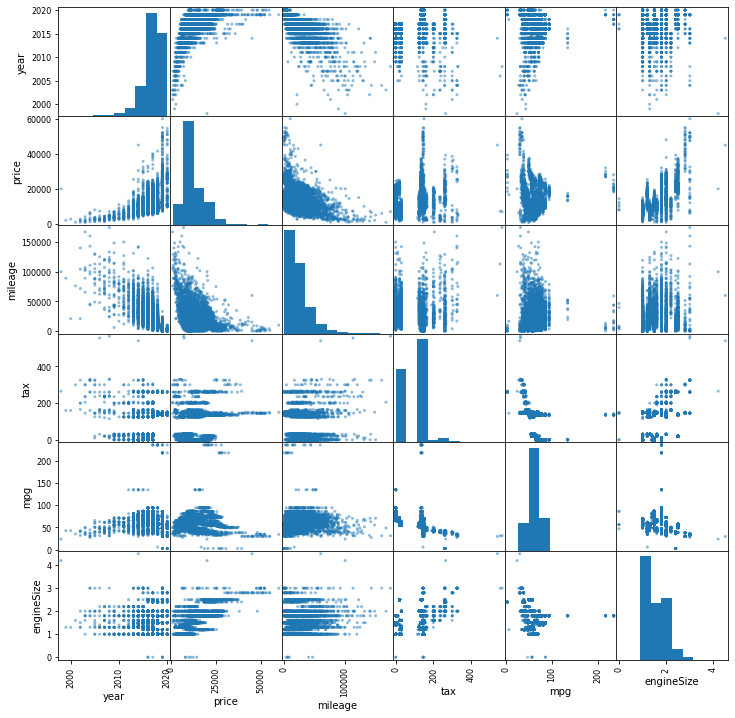

In [62]:
# Scatter matrix of all the features
pd.plotting.scatter_matrix(df, figsize=(12,12));

The features 'year' vs. 'mileage' seems pretty linear (with a negative relationship).
As well, 'year' vs. 'price' seems linear.

# Categorical Data

In [63]:
# Check out the different models - looks like 18 types.
df['model'].value_counts()

 Yaris            2117
 Aygo             1940
 Auris             709
 C-HR              479
 RAV4              467
 Corolla           265
 Prius             232
 Verso             114
 Avensis           114
 Hilux              85
 GT86               73
 Land Cruiser       51
 PROACE VERSO       15
 Supra              12
 Camry              11
 IQ                  8
 Urban Cruiser       4
 Verso-S             3
Name: model, dtype: int64

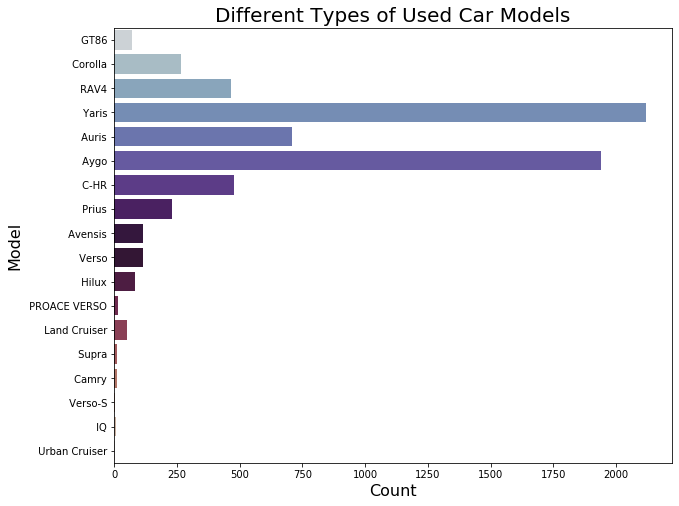

In [64]:
# Which are the most common in the dataset - 'Yaris' and 'Aygo'
fig = plt.figure(figsize = (10,8))
sns.countplot(y=df['model'], palette="twilight")
plt.xlabel("Count", fontsize = 16)
plt.ylabel("Model", fontsize = 16)
plt.title("Different Types of Used Car Models", fontsize = 20)
plt.show()

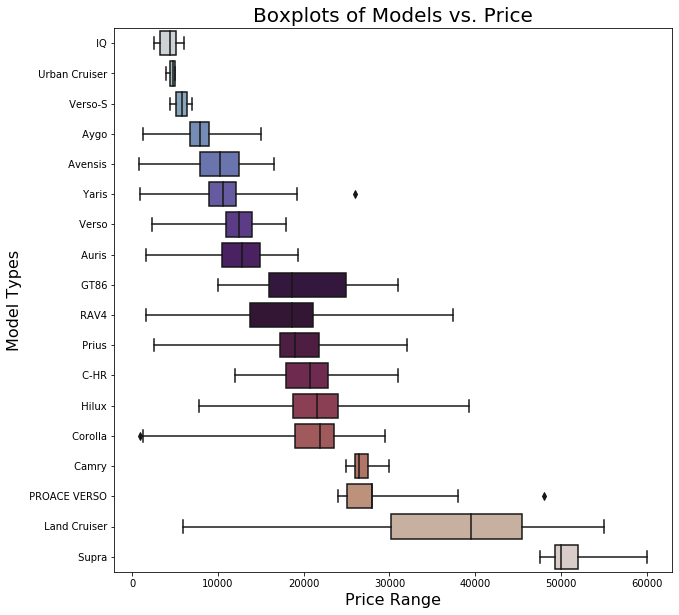

In [65]:
# How do their prices compare to other models?
fig = plt.figure(figsize = (10,10))
sns.boxplot(x="price", y="model", whis=4, data=df, palette="twilight",
           order = df.groupby('model').median().sort_values(by = 'price').index)
plt.xlabel("Price Range", fontsize = 16)
plt.ylabel("Model Types", fontsize = 16)
plt.title("Boxplots of Models vs. Price", fontsize = 20)
plt.show()

In [66]:
# Types of transmissions
df['transmission'].value_counts()

Manual       3793
Automatic    2651
Semi-Auto     254
Other           1
Name: transmission, dtype: int64

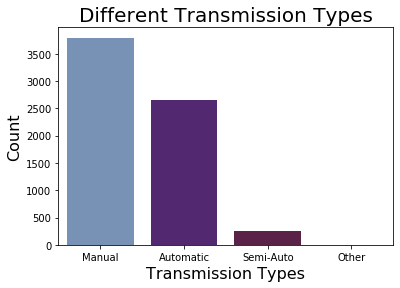

In [67]:
# Manual cars are still most common in the UK?
sns.countplot(df['transmission'],palette="twilight")
plt.xlabel("Transmission Types", fontsize = 16)
plt.ylabel("Count", fontsize = 16)
plt.title("Different Transmission Types", fontsize = 20)
plt.show()

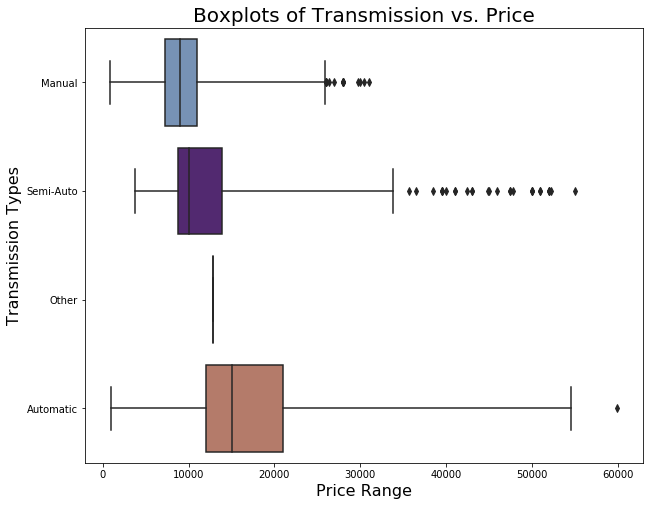

In [68]:
# Manual cars seem to be slightly cheaper than other types
fig = plt.figure(figsize = (10,8))
sns.boxplot(x="price", y="transmission", whis=4, data=df, palette="twilight",
           order = df.groupby('transmission').median().sort_values(by = 'price').index)
plt.xlabel("Price Range", fontsize = 16)
plt.ylabel("Transmission Types", fontsize = 16)
plt.title("Boxplots of Transmission vs. Price", fontsize = 20)
plt.show()

In [69]:
# What is this 'Other' fuel type? Electric?
df['fuelType'].value_counts()

Petrol    4058
Hybrid    2040
Diesel     496
Other      105
Name: fuelType, dtype: int64

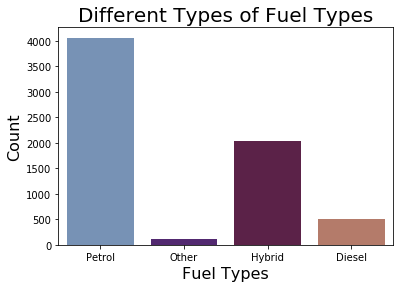

In [70]:
# Standard gas cars and the most common
sns.countplot(df['fuelType'],palette="twilight")
plt.xlabel("Fuel Types", fontsize = 16)
plt.ylabel("Count", fontsize = 16)
plt.title("Different Types of Fuel Types", fontsize = 20)
plt.show()

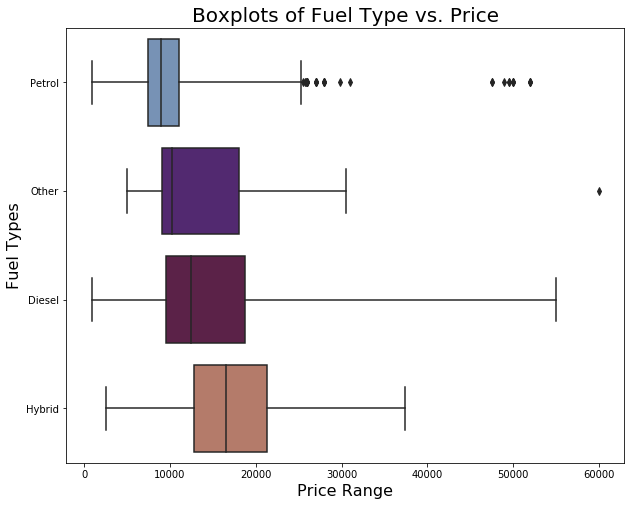

In [71]:
# Hybrids are the most expensive on average.
fig = plt.figure(figsize = (10,8))
sns.boxplot(x="price", y="fuelType", whis=4, data=df, palette="twilight",
           order = df.groupby('fuelType').median().sort_values(by = 'price').index)
plt.xlabel("Price Range", fontsize = 16)
plt.ylabel("Fuel Types", fontsize = 16)
plt.title("Boxplots of Fuel Type vs. Price", fontsize = 20)
plt.show()

In [72]:
# What am I going to do with this 'year' feature?
df['year'].value_counts()

2017    2015
2019    1265
2018    1014
2016     990
2015     522
2014     351
2013     203
2020     127
2012      42
2011      40
2009      29
2007      20
2008      19
2010      18
2005      12
2006      11
2004       7
2003       6
2002       4
1998       1
2001       1
1999       1
2000       1
Name: year, dtype: int64

In [73]:
# Make a new integer column of car age.
df['carAge'] = 2020 - df['year']
df.head()

,model,year,price,transmission,mileage,fuelType,tax,mpg,engineSize,carAge
0,GT86,2016,16000,Manual,24089,Petrol,265,36.2,2.0,4
1,GT86,2017,15995,Manual,18615,Petrol,145,36.2,2.0,3
2,GT86,2015,13998,Manual,27469,Petrol,265,36.2,2.0,5
3,GT86,2017,18998,Manual,14736,Petrol,150,36.2,2.0,3
4,GT86,2017,17498,Manual,36284,Petrol,145,36.2,2.0,3


In [74]:
# Is this age integer any different than the year?
df = df.drop('year', axis=1)
df.head()

In [75]:
df.head()

,model,price,transmission,mileage,fuelType,tax,mpg,engineSize,carAge
0,GT86,16000,Manual,24089,Petrol,265,36.2,2.0,4
1,GT86,15995,Manual,18615,Petrol,145,36.2,2.0,3
2,GT86,13998,Manual,27469,Petrol,265,36.2,2.0,5
3,GT86,18998,Manual,14736,Petrol,150,36.2,2.0,3
4,GT86,17498,Manual,36284,Petrol,145,36.2,2.0,3


## Binning Categorical Data

In [76]:
# Use One Hot Encoding to change all categorical data to 0 and 1's
final_df = pd.concat([df, pd.get_dummies(df.model, drop_first=True),
                          pd.get_dummies(df.fuelType, drop_first=True), 
                          pd.get_dummies(df.transmission, drop_first=True)], 
                     axis = 1)
final_df.head()

,model,price,transmission,mileage,fuelType,tax,mpg,engineSize,carAge,Auris,...,Verso-S,Yaris,Diesel,Hybrid,Other,Petrol,Automatic,Manual,Other,Semi-Auto
0,GT86,16000,Manual,24089,Petrol,265,36.2,2.0,4,0,...,0,0,0,0,0,1,0,1,0,0
1,GT86,15995,Manual,18615,Petrol,145,36.2,2.0,3,0,...,0,0,0,0,0,1,0,1,0,0
2,GT86,13998,Manual,27469,Petrol,265,36.2,2.0,5,0,...,0,0,0,0,0,1,0,1,0,0
3,GT86,18998,Manual,14736,Petrol,150,36.2,2.0,3,0,...,0,0,0,0,0,1,0,1,0,0
4,GT86,17498,Manual,36284,Petrol,145,36.2,2.0,3,0,...,0,0,0,0,0,1,0,1,0,0


In [79]:
final_df =  final_df.drop(['model','transmission','fuelType'], axis = 1)

In [80]:
final_df.head()

,price,mileage,tax,mpg,engineSize,carAge,Auris,Avensis,Aygo,C-HR,...,Verso-S,Yaris,Diesel,Hybrid,Other,Petrol,Automatic,Manual,Other,Semi-Auto
0,16000,24089,265,36.2,2.0,4,0,0,0,0,...,0,0,0,0,0,1,0,1,0,0
1,15995,18615,145,36.2,2.0,3,0,0,0,0,...,0,0,0,0,0,1,0,1,0,0
2,13998,27469,265,36.2,2.0,5,0,0,0,0,...,0,0,0,0,0,1,0,1,0,0
3,18998,14736,150,36.2,2.0,3,0,0,0,0,...,0,0,0,0,0,1,0,1,0,0
4,17498,36284,145,36.2,2.0,3,0,0,0,0,...,0,0,0,0,0,1,0,1,0,0


# Continuous Data

In [21]:
# We know that engine size is a good predictore of price
df['engineSize'].value_counts()

1.0    2038
1.5    1419
1.8    1289
1.3     600
2.0     394
1.2     300
2.5     247
1.6     166
2.4      70
2.2      58
1.4      40
2.8      36
3.0      34
0.0       6
4.2       1
4.5       1
Name: engineSize, dtype: int64

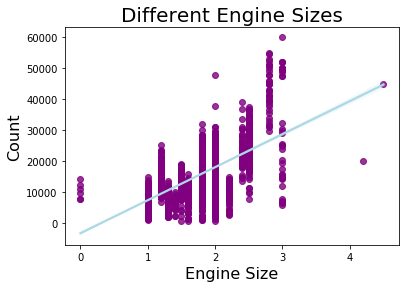

In [24]:
# This regplot shows the direct relationship of price and engine size.
sns.regplot(data=df, x="engineSize", y="price", scatter_kws={"color": "purple"}, line_kws={"color": "lightblue"})
plt.xlabel("Engine Size", fontsize = 16)
plt.ylabel("Count", fontsize = 16)
plt.title("Different Engine Sizes", fontsize = 20)
plt.show()

In [22]:
# Are we sure these values aren't in kilometers? But the UK uses miles and gallons!
df['mpg'].value_counts()

69.0    674
68.9    472
56.5    466
47.9    408
74.3    362
       ... 
30.7      1
30.4      1
83.1      1
37.2      1
40.9      1
Name: mpg, Length: 81, dtype: int64

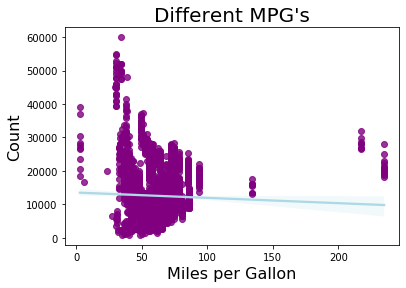

In [56]:
# I would think that higher miles per gallon would decrease the price?
sns.regplot(data=df, x="mpg", y="price", scatter_kws={"color": "purple"}, line_kws={"color": "lightblue"})
plt.xlabel("Miles per Gallon", fontsize = 16)
plt.ylabel("Count", fontsize = 16)
plt.title("Different MPG's", fontsize = 20)
plt.show()

In [98]:
# Should I get rid of the outliers?
df['mileage'].describe()

count      6699.000000
mean      22889.588745
std       19109.288501
min           2.000000
25%        9488.500000
50%       18571.000000
75%       31059.500000
max      174419.000000
Name: mileage, dtype: float64

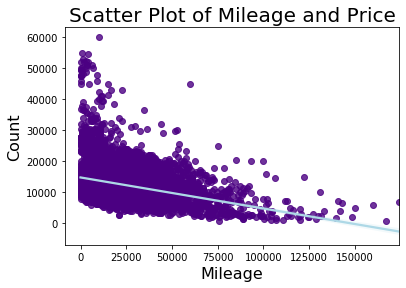

In [97]:
# A slight negative relationship here
sns.regplot(data=df, x="mileage", y="price", scatter_kws={"color": "indigo"}, line_kws={"color": "lightblue"})
plt.xlabel("Mileage", fontsize = 16)
plt.ylabel("Count", fontsize = 16)
plt.title("Scatter Plot of Mileage and Price", fontsize = 20)
plt.show()

In [25]:
# Should I bin these - they don't seem continuous?
df['tax'].value_counts()

145    2065
0      1787
135     678
30      585
150     527
20      250
140     223
125     193
260      92
200      74
160      41
265      41
205      28
10       23
165      23
235      21
300      16
325      13
240       5
330       4
305       2
565       1
540       1
190       1
250       1
115       1
120       1
155       1
555       1
Name: tax, dtype: int64

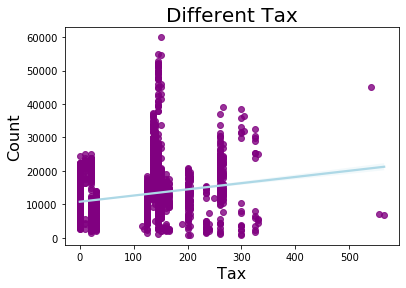

In [78]:
# Not sure how cars are taxed in the UK.
sns.regplot(data=df, x="tax", y="price", scatter_kws={"color": "purple"}, line_kws={"color": "lightblue"})
plt.xlabel("Tax", fontsize = 16)
plt.ylabel("Count", fontsize = 16)
plt.title("Different Tax", fontsize = 20)
plt.show()

In [111]:
df.tax.describe()

count    6699.000000
mean       94.549933
std        73.942649
min         0.000000
25%         0.000000
50%       135.000000
75%       145.000000
max       565.000000
Name: tax, dtype: float64

In [112]:
# Three std above the mean
df.tax.mean() + df.tax.std()*3

316.37788071178926

In [113]:
# How many are there?
len(df.loc[df["tax"] > 316.37])

20

In [114]:
# Let's get rid of the outliers
df = df[df.tax < 316.37]

Text(0.5, 1.0, 'engineSize')

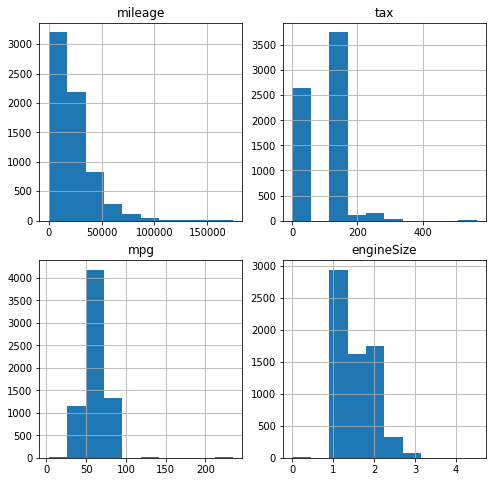

In [106]:
# I just want to look at a couple of these again BEFORE the transformation.
new_figure = plt.figure(figsize=(8,8))

ax1 = plt.subplot(2, 2, 1)
df.mileage.hist(ax=ax1)
ax1.set_title("mileage")

ax2 = plt.subplot(2, 2, 2)
df.tax.hist(ax=ax2)
ax2.set_title('tax')

ax3 = plt.subplot(2, 2, 3)
df.mpg.hist(ax=ax3)
ax3.set_title("mpg")

ax4 = plt.subplot(2, 2, 4)
df.engineSize.hist(ax=ax4)
ax4.set_title('engineSize')

In [109]:
# Perform log transformation - import numpy
import numpy as np
logmpg = np.log(df["mpg"])
logsize = np.log(df["engineSize"])
logmileage = np.log(df["mileage"])
logtax = np.log(df["tax"])

# Switch the Standardization into the original data
final_df["mpg"] = (logmpg-np.mean(logmpg))/np.sqrt(np.var(logmpg))
final_df["engineSize"] = (logsize-np.mean(logsize))/np.sqrt(np.var(logsize))
final_df["mileage"] = (logmileage-np.mean(logmileage))/np.sqrt(np.var(logmileage))
final_df["tax"] = (logtax-np.mean(logtax))/np.sqrt(np.var(logtax))

Text(0.5, 1.0, 'engineSize')

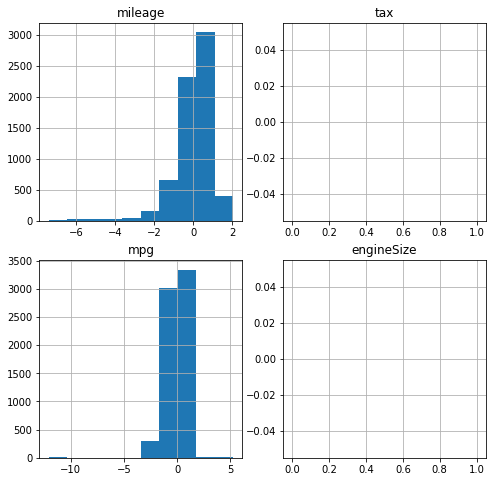

In [110]:
# I just want to look at a couple of these again AFTER the transformation.
new_figure = plt.figure(figsize=(8,8))

ax1 = plt.subplot(2, 2, 1)
final_df.mileage.hist(ax=ax1)
ax1.set_title("mileage")

ax2 = plt.subplot(2, 2, 2)
final_df.tax.hist(ax=ax2)
ax2.set_title('tax')

ax3 = plt.subplot(2, 2, 3)
final_df.mpg.hist(ax=ax3)
ax3.set_title("mpg")

ax4 = plt.subplot(2, 2, 4)
final_df.engineSize.hist(ax=ax4)
ax4.set_title('engineSize')

# Test/Train Split

In [81]:
y =  final_df['price']

In [90]:
y.head()

0    16000
1    15995
2    13998
3    18998
4    17498
Name: price, dtype: int64

In [82]:
X = final_df.drop('price', axis=1)

In [89]:
X.head()

,mileage,tax,mpg,engineSize,carAge,Auris,Avensis,Aygo,C-HR,Camry,...,Verso-S,Yaris,Diesel,Hybrid,Other,Petrol,Automatic,Manual,Other,Semi-Auto
0,24089,265,36.2,2.0,4,0,0,0,0,0,...,0,0,0,0,0,1,0,1,0,0
1,18615,145,36.2,2.0,3,0,0,0,0,0,...,0,0,0,0,0,1,0,1,0,0
2,27469,265,36.2,2.0,5,0,0,0,0,0,...,0,0,0,0,0,1,0,1,0,0
3,14736,150,36.2,2.0,3,0,0,0,0,0,...,0,0,0,0,0,1,0,1,0,0
4,36284,145,36.2,2.0,3,0,0,0,0,0,...,0,0,0,0,0,1,0,1,0,0


In [83]:
# Split into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=123)

# Standard Scaler

In [84]:
# Applying Standard scaling to get optimized result
stdscr = StandardScaler()

X_train = stdscr.fit_transform(X_train)

X_test = stdscr.fit_transform(X_test)

# Model

In [104]:
model = sm.OLS(y, X).fit()

In [105]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.928
Model:                            OLS   Adj. R-squared:                  0.928
Method:                 Least Squares   F-statistic:                     3074.
Date:                Tue, 13 Oct 2020   Prob (F-statistic):               0.00
Time:                        10:22:34   Log-Likelihood:                -59355.
No. Observations:                6699   AIC:                         1.188e+05
Df Residuals:                    6670   BIC:                         1.190e+05
Df Model:                          28                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
mileage           -0.0621      0.002    -36.608      0.000      -0.065      -0.059
tax               -3.7980      0.365    -10.408      0.000      -4.513      -3.083
mpg               -9.6607      2.086     -4.630      0.000     -13.751      -5.571
engineSize      3009.4173    170.668     17.633      0.000    2674.854    3343.981
carAge          -781.8685     14.584    -53.610      0.000    -810.458    -753.279
 Auris         -4011.0129    125.437    -31.976      0.000   -4256.910   -3765.115
 Avensis       -2689.8787    191.347    -14.058      0.000   -3064.980   -2314.777
 Aygo          -6695.9070    160.336    -41.762      0.000   -7010.217   -6381.597
 C-HR           1549.2239    134.008     11.561      0.000    1286.525    1811.923
 Camry          2828.5746    510.947      5.536      0.000    1826.956    3830.193
 Corolla        1004.9643    149.450      6.724      0.000     711.994    1297.934
 GT86           2168.2207    226.875      9.557      0.000    1723.474    2612.968
 Hilux          4382.0188    269.881     16.237      0.000    3852.967    4911.071
 IQ            -4318.5981    594.433     -7.265      0.000   -5483.877   -3153.319
 Land Cruiser   1.873e+04    351.207     53.333      0.000     1.8e+04    1.94e+04
 PROACE VERSO   9572.1518    449.132     21.313      0.000    8691.710    1.05e+04
 Prius           976.4968    169.191      5.772      0.000     644.827    1308.166
 RAV4            895.3738    153.996      5.814      0.000     593.493    1197.255
 Supra          2.634e+04    537.700     48.982      0.000    2.53e+04    2.74e+04
 Urban Cruiser -4013.1648    820.346     -4.892      0.000   -5621.305   -2405.024
 Verso         -2807.7335    183.550    -15.297      0.000   -3167.550   -2447.917
 Verso-S       -3760.3926    944.857     -3.980      0.000   -5612.614   -1908.171
 Yaris         -5565.8748    121.712    -45.730      0.000   -5804.469   -5327.280
Diesel          6701.7067    265.713     25.222      0.000    6180.825    7222.588
Hybrid          9940.1282    284.172     34.979      0.000    9383.060    1.05e+04
Other           9643.1842    293.934     32.807      0.000    9066.979    1.02e+04
Petrol          8298.2049    245.171     33.847      0.000    7817.592    8778.818
Automatic       8712.4577    292.218     29.815      0.000    8139.616    9285.299
Manual          7483.6581    292.056     25.624      0.000    6911.134    8056.182
Other           9608.8805   1483.196      6.478      0.000    6701.342    1.25e+04
Semi-Auto       8778.2278    305.565     28.728      0.000    8179.222    9377.234
==============================================================================
Omnibus:                     2696.681   Durbin-Watson:                   1.843
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            62981.278
Skew:                   

In [99]:
# Apply model to the train set
from sklearn.linear_model import LinearRegression
linreg = LinearRegression()
linreg.fit(X_train, y_train)
LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [100]:
# Calculate predictions on training and test sets
y_hat_train = linreg.predict(X_train)
y_hat_test = linreg.predict(X_test)

# Calculate training and test residuals
train_residuals = y_hat_train - y_train
test_residuals = y_hat_test - y_test

In [101]:
#Calculate the Mean Squared Error (MSE)
from sklearn.metrics import mean_squared_error

train_mse = mean_squared_error(y_train, y_hat_train)
test_mse = mean_squared_error(y_test, y_hat_test)

print('Train Mean Squarred Error:', train_mse)
print('Test Mean Squarred Error:', test_mse)

Train Mean Squarred Error: 2863792.6968429065
Test Mean Squarred Error: 5.120556066099232e+27


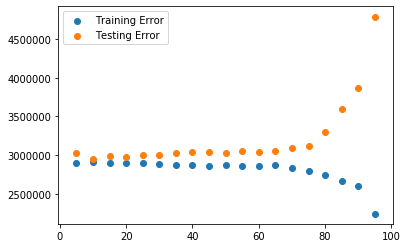

In [102]:
#Evaluate the effect of train-test split 
import random
random.seed(8)
train_err = []
test_err = []
t_sizes = list(range(5,100,5))
for t_size in t_sizes:
    temp_train_err = []
    temp_test_err = []
    for i in range(100):
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=t_size/100)
        linreg.fit(X_train, y_train)
        y_hat_train = linreg.predict(X_train)
        y_hat_test = linreg.predict(X_test)
        temp_train_err.append(mean_squared_error(y_train, y_hat_train))
        temp_test_err.append(mean_squared_error(y_test, y_hat_test))
    train_err.append(np.mean(temp_train_err))
    test_err.append(np.mean(temp_test_err))
plt.scatter(t_sizes, train_err, label='Training Error')
plt.scatter(t_sizes, test_err, label='Testing Error')
plt.legend()

## Cross Validation Score

In [103]:
#Cross Validation Score of top 5 features
cv_5_results = cross_val_score(linreg, X, y, cv=5, scoring='neg_mean_squared_error')
cv_5_results

array([ -5197495.53449304,  -1734465.78325065, -22669481.89331001,
        -1076430.63792422, -42034305.81027334])

# Summary

# Future Recommendations